In [1]:
%config Completer.use_jedi = False

import os
os.chdir('data')
print(os.listdir())

['ham', 'spam', '.DS_Store']


In [2]:
print('number of email in ham folder: ',len(os.listdir('ham')))
print('number of email in spam folder: ',len(os.listdir('spam')))  

number of email in ham folder:  3672
number of email in spam folder:  1500


In [3]:
# open python and nltk packages needed for processing
import sys
import random
import nltk
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import re
from collections import defaultdict


In [4]:
# function to read spam and ham files, train and test a classifier
def processspamham(spam_limit = 1500, ham_limit = 3672):
    # convert the limit argument from a string to an int
    # limit = int(limitStr)

    # start lists for spam and ham email texts
    hamtexts = []
    spamtexts = []
    # process all files in directory that end in .txt up to the limit
    #    assuming that the emails are sufficiently randomized
    for file in os.listdir("./spam"):
         if (file.endswith(".txt")) and (len(spamtexts) < spam_limit):
            # open file for reading and read entire file into a string
            f = open("./spam/" + file, 'r', encoding="latin-1")
            spamtexts.append(f.read())
            f.close()
    for file in os.listdir("./ham"):
         if (file.endswith(".txt")) and (len(hamtexts) < ham_limit):
            # open file for reading and read entire file into a string
            f = open("./ham/" + file, 'r', encoding="latin-1")
            hamtexts.append(f.read())
            f.close()

    # possibly filter tokens
    regex = re.compile('[\W+]|[\d+]')        
    stop_words = set(stopwords.words('english')) 
        
    # create list of mixed spam and ham email documents as (list of words, label)
    emaildocs = []
    # add all the spam
    for spam in spamtexts:
        tokens = nltk.word_tokenize(regex.sub(' ',spam))
        clean_tokens = [w for w in tokens if not w in stop_words]
        emaildocs.append((clean_tokens, 'spam'))
    # add all the regular emails
    for ham in hamtexts:
        tokens = nltk.word_tokenize(regex.sub(' ', ham))
        clean_tokens = [w for w in tokens if not w in stop_words]
        emaildocs.append((clean_tokens, 'ham'))

    # randomize the list
    random.shuffle(emaildocs)
    return pd.DataFrame(emaildocs,columns=["tokens","label"])

    

In [5]:
def vectorize(tokens):
    features = defaultdict(int)
    for token in tokens:
        features[token] += 1
    return features

   
def vectorlizedspamham(spam_limit = 1500, ham_limit = 3672):
    emails = processspamham(spam_limit, ham_limit)
    vector = map(vectorize, emails.tokens.tolist())
            
    return pd.DataFrame(vector).fillna(0), emails.label.tolist()
    

              precision    recall  f1-score   support

         ham       0.88      1.00      0.93      1213
        spam       1.00      0.65      0.79       494

    accuracy                           0.90      1707
   macro avg       0.94      0.83      0.86      1707
weighted avg       0.91      0.90      0.89      1707



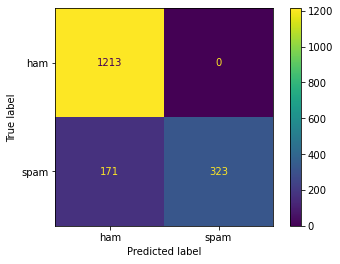

In [6]:
X, y = vectorlizedspamham()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

pipeline = Pipeline([('tfid', TfidfTransformer()),
                     ('nbc', MultinomialNB())]).fit(X_train,y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

labels = pipeline.steps[-1][1].classes_
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=labels)
disp.plot()
plt.show()

There is one intesting things I have noted while editing the preprocessing function given with the homework. The function will take a limit with apply to both `spam` and `ham` emails. This would make sense if we are trying to save processing power. However we also will run in to problems like different distribution of the input data. Natually the number of spam we get will be much lesser than real emails. 1500/3672, in this case. If we munipulate the ratio, the model won't be less accuarte in real production environment. Here is an example:

              precision    recall  f1-score   support

         ham       0.93      0.92      0.92       166
        spam       0.92      0.93      0.92       164

    accuracy                           0.92       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.92      0.92       330



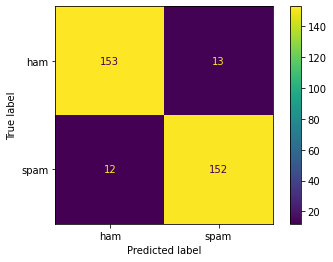

In [7]:
X2, y2 = vectorlizedspamham(500,500)


X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33)

pipeline2 = Pipeline([('tfid', TfidfTransformer()),
                      ('nbc', MultinomialNB())]).fit(X_train2,y_train2)

y_pred2 = pipeline2.predict(X_test2)

print(classification_report(y_test2, y_pred2))

cm2 = confusion_matrix(y_test2, y_pred2, labels=labels)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                            display_labels=labels)
disp2.plot()
plt.show()

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98      1185
        spam       0.95      0.95      0.95       522

    accuracy                           0.97      1707
   macro avg       0.96      0.96      0.96      1707
weighted avg       0.97      0.97      0.97      1707



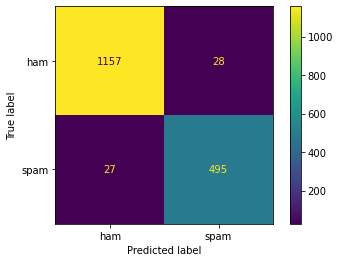

In [8]:
def dummy(tokens):
    return tokens

downsampled_emails = processspamham(500,500)

X3 = downsampled_emails.tokens.tolist()
y3 = downsampled_emails.label.tolist()

emails = processspamham()
X4 = emails.tokens.tolist()
y4 = emails.label.tolist()

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.33)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.33)

pipeline3 = Pipeline([('count', CountVectorizer(tokenizer=dummy, preprocessor=dummy)),
                      ('tfid', TfidfTransformer()),
                      ('nbc', MultinomialNB())]).fit(X_train3,y_train3)

y_pred4 = pipeline3.predict(X_test4)

print(classification_report(y_test4, y_pred4))

cm4 = confusion_matrix(y_test4, y_pred4, labels=labels)
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4,
                            display_labels=labels)
disp4.plot()
plt.show()

In [9]:
X2

,Subject,investment,idea,oi,gas,advisory,oil,entered,ong,term,...,pot,phoenican,ino,drunk,progressive,pots,refuse,phoenicianl,marcia,resumel
0,1,3.0,1.0,7.0,15.0,2.0,10.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,1,2.0,0.0,9.0,15.0,2.0,8.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [10]:
downsampled_emails

,tokens,label
0,"[Subject, list, dirty, list, let, know, lookin...",ham
1,"[Subject, epgt, gloria, difference, two, pipes...",ham
2,"[Subject, cornhusker, plants, become, external...",ham
3,"[Subject, free, report, euro, tells, gain]",spam
4,"[Subject, eastrans, nomination, change, effect...",ham
...,...,...
995,"[Subject, ad, felt, stiffen, goo, hair, face, ...",spam
996,"[Subject, urgent, reply, overseas, stake, lott...",spam
997,"[Subject, dating, service, nauuughty, minded, ...",spam
998,"[Subject, may, activity, survey, daren, please...",ham


Also one important things I have realized is that words like Subject, To, CC, etc., which come with all the e-mails. Would be included in all the documents.

/home/jim/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


	-7.0714	Subject        
	-7.3682	http           
	-7.5554	com            
	-7.6032	_              
	-7.7624	www            
	-7.8423	click          
	-7.8490	get            
	-8.0086	e              
	-8.0665	online         
	-8.0987	free           
	-8.1242	r              
	-8.1465	us             
	-8.1589	email          
	-8.1598	best           
	-8.1863	money          
	-8.2063	new            
	-8.2174	time           
	-8.2479	v              
	-8.2505	save           
	-8.3105	prices         


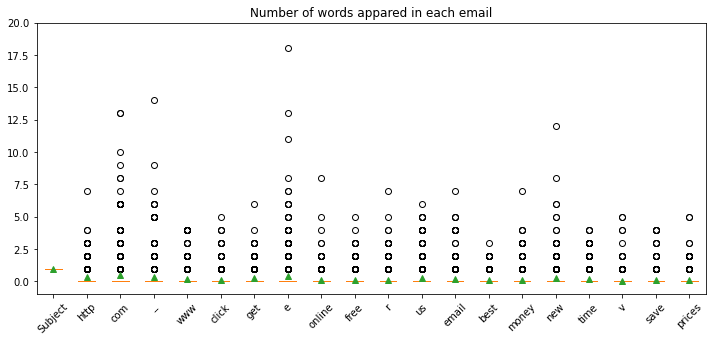

In [11]:
pipeline4 = Pipeline([('count', CountVectorizer(tokenizer=dummy, preprocessor=dummy)),
                      ('tfidf', TfidfTransformer()),
                      ('nbc', MultinomialNB())]).fit(X_train4,y_train4)

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    word_list = []
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        word_list.append(fn_2)
        print ("\t%.4f\t%-15s" % ( coef_2, fn_2))
    plt.figure(figsize=(12,5))
    plt.title('Number of words appared in each email')
    plt.boxplot(X2[word_list],showmeans=True,vert=True)
    plt.xticks(ticks=list(range(1,21)),labels=word_list,rotation=45)
    plt.ylim(-1,20)
show_most_informative_features(pipeline4['count'],pipeline4['nbc'])